In [1]:
import requests as r
from bs4 import BeautifulSoup

### Getting translations from wiki-data based on ids and desired translations

In [2]:
import json

'''Simple function for getting json (not really needed anymore)'''
def get_json(wiki_id):
    req = r.get(f'https://www.wikidata.org/wiki/Special:EntityData/{wiki_id}.json')

    j = json.loads(req.text)

    return j


'''Take in a wiki id, and an optional list of desired translations(must match language names)
    return a dictionary containing translations
    if no desired translations are passed returns all translations
'''
def get_translations_from_id(wiki_id:str, desired_translations: list = None):
        req = r.get(f'https://www.wikidata.org/wiki/Special:EntityData/{wiki_id}.json')
        
        if req.status_code == 429:
            print("STOP REQUESTING BEFORE YOU GET BANNED")

        j = json.loads(req.text)
        
        if desired_translations:
            out_ = {}
            for translation in desired_translations:
                try:
                    out_[translation] = j['entities'][wiki_id]['labels'][translation]['value']
                except:
                    pass
                    #print(f"Encountered error retrieving {translation}")
        else:
            return j['entities'][wiki_id]['labels']


        return out_ 
            


In [3]:
#getting specific translations 
es = get_translations_from_id("Q110246392", ['fr', 'de', 'th'])
es

{'fr': {'language': 'fr', 'value': 'Little Women'},
 'de': {'language': 'de', 'value': 'Little Women'},
 'th': {'language': 'th', 'value': 'สามพี่น้อง'}}

In [4]:
#getting all translations
all_of_em = get_translations_from_id("Q110246392")
all_of_em

{'en': {'language': 'en', 'value': 'Little Women'},
 'ar': {'language': 'ar', 'value': 'نساء صغيرات'},
 'id': {'language': 'id', 'value': 'Little Women'},
 'ko': {'language': 'ko', 'value': '작은 아씨들'},
 'es': {'language': 'es', 'value': 'Las hermanas'},
 'zh': {'language': 'zh', 'value': '小女子'},
 'vi': {'language': 'vi', 'value': 'Little Women'},
 'ja': {'language': 'ja', 'value': '新・若草物語'},
 'fa': {'language': 'fa', 'value': 'زنان کوچک'},
 'ms': {'language': 'ms', 'value': 'Little Women'},
 'ru': {'language': 'ru', 'value': 'Маленькие женщины'},
 'zh-tw': {'language': 'zh-tw', 'value': '小女子'},
 'fr': {'language': 'fr', 'value': 'Little Women'},
 'de': {'language': 'de', 'value': 'Little Women'},
 'th': {'language': 'th', 'value': 'สามพี่น้อง'},
 'uz': {'language': 'uz', 'value': 'Little Women'},
 'it': {'language': 'it', 'value': 'Piccole donne'},
 'zh-hans': {'language': 'zh-hans', 'value': '小女子'}}

### Query for multiple items at once

> this does not save resources only makes it easier on our end
> Potentially want to look into a better way to reduce requests sent to wikidata

In [16]:
'''Function to query for multiple wiki-id translations at once'''
def aggregate_multiple(wiki_ids: list[str], translations: list[str]=None):
    out_ = {}
    for wiki_id in wiki_ids:
        try:
            t_out_ = get_translations_from_id(wiki_id, translations)
            out_[wiki_id] = t_out_
        except Exception as e:
            print(f"Unable to get translations for {wiki_id}\n{e}")

    return out_


In [6]:
t = aggregate_multiple(["Q110246392", "Q910656", "Q733195"], ['it', 'fr', 'ru', 'ja'])
t

Encountered error retrieving ru


{'Q110246392': {'it': {'language': 'it', 'value': 'Piccole donne'},
  'fr': {'language': 'fr', 'value': 'Little Women'},
  'ru': {'language': 'ru', 'value': 'Маленькие женщины'},
  'ja': {'language': 'ja', 'value': '新・若草物語'}},
 'Q910656': {'it': {'language': 'it', 'value': 'olio di neem'},
  'fr': {'language': 'fr', 'value': 'Huile de neem'},
  'ja': {'language': 'ja', 'value': 'ニームオイル'}},
 'Q733195': {'it': {'language': 'it', 'value': 'Repubblica Galattica'},
  'fr': {'language': 'fr', 'value': 'République galactique'},
  'ru': {'language': 'ru', 'value': 'Галактическая Республика'},
  'ja': {'language': 'ja', 'value': '銀河共和国'}}}

In [7]:
t

{'Q110246392': {'it': {'language': 'it', 'value': 'Piccole donne'},
  'fr': {'language': 'fr', 'value': 'Little Women'},
  'ru': {'language': 'ru', 'value': 'Маленькие женщины'},
  'ja': {'language': 'ja', 'value': '新・若草物語'}},
 'Q910656': {'it': {'language': 'it', 'value': 'olio di neem'},
  'fr': {'language': 'fr', 'value': 'Huile de neem'},
  'ja': {'language': 'ja', 'value': 'ニームオイル'}},
 'Q733195': {'it': {'language': 'it', 'value': 'Repubblica Galattica'},
  'fr': {'language': 'fr', 'value': 'République galactique'},
  'ru': {'language': 'ru', 'value': 'Галактическая Республика'},
  'ja': {'language': 'ja', 'value': '銀河共和国'}}}

### Getting Ids from string queries

> will return first result if it finds it as the answer (not neccisarily true)

In [21]:
# Now need to find a good way to query / find the ids from a name
#  (ID is also provided via training data but it might not hurt to have this feature)
from bs4 import BeautifulSoup
import urllib.parse

'''Function to attempt to get a wiki id from a string name (throws exceptions if unable to find a first result)
    Naively returns the first result as the "interpreted" 
'''
def query_for_id(name: str):
    encoded = urllib.parse.urlencode({"search": name})
    req = r.get(f'https://www.wikidata.org/w/index.php?{encoded}')

    

    try:
        soup = BeautifulSoup(req.text, 'html.parser')
        result = soup.find('div', class_="mw-search-result-heading")
        link = result.find('a')
        return link['href'].split("/")[2]
        
    except Exception as e:
        print(f"Encountered : {e}\n\t when querying for {name}")

In [9]:
query_for_id("Galactic Republic")

'Q733195'

In [18]:
from tqdm import tqdm

def get_instance_of(wiki_id:str):
    req = r.get(f'https://www.wikidata.org/wiki/{wiki_id}')
    soup = BeautifulSoup(req.text)
    title = soup.find('span', class_='wikibase-title-label')
    d = soup.find('div', class_="wikibase-snakview-value wikibase-snakview-variation-valuesnak")
    a = d.find('a')
    
    return (title.text, a.text)

def collect_instances(ids:list[str]):
    instances = []
    for id in tqdm(ids, desc="Scraping info"):
        iof = get_instance_of(id)
        instances.append(iof)
    
    return instances


In [11]:
get_instance_of('Q56881140')

('Little Women', 'film')

In [23]:
import pandas as pd
import os 

#Calculating the total amount of ids per langauge 

total_instances = []
lang_ids = {}
for lang in os.listdir('../data/train'):
    joi = pd.read_json(f'../data/train/{lang}/train.jsonl', lines=True)
    for i, row in joi.iterrows():
        try:
            lang_ids[lang].extend(row['entities'])
        except:
            lang_ids[lang] = row['entities']

In [ ]:
from collections import Counter
c = Counter()

#Entire count of entities over dataset 
for v in lang_ids.values():
    c.update(v)

print(len(c.most_common()))
print(c.most_common())

c = list(c.keys())
with open('../data/unique_entities.txt', 'w') as f:
    f.write('\n'.join(c))

3847
[('Q30', 2759), ('Q362', 714), ('Q32096', 555), ('Q6256', 458), ('Q41254', 390), ('Q15228', 388), ('Q17', 385), ('Q19020', 371), ('Q16', 365), ('Q99', 359), ('Q46', 346), ('Q183', 332), ('Q142', 325), ('Q145', 303), ('Q159', 302), ('Q79', 301), ('Q155', 290), ('Q15', 286), ('Q46525', 273), ('Q265538', 272), ('Q49', 262), ('Q96', 249), ('Q21', 244), ('Q515', 219), ('Q361', 215), ('Q38', 204), ('Q148', 204), ('Q220', 194), ('Q48', 182), ('Q18', 178), ('Q782', 158), ('Q483412', 151), ('Q44523', 151), ('Q35525', 148), ('Q29468', 147), ('Q11424', 145), ('Q8676', 143), ('Q29552', 142), ('Q7347', 141), ('Q5389', 134), ('Q8337', 131), ('Q668', 128), ('Q45875', 126), ('Q11679', 125), ('Q8740', 123), ('Q571', 121), ('Q198', 121), ('Q29', 120), ('Q1384', 118), ('Q194318', 115), ('Q8502', 111), ('Q4470', 109), ('Q9202', 108), ('Q38370', 107), ('Q190214', 103), ('Q812', 102), ('Q1299', 101), ('Q8663', 101), ('Q60', 100), ('Q2', 100), ('Q462', 96), ('Q846570', 95), ('Q5107', 94), ('Q83497', 93)

In [22]:
import time
import json
from tqdm import tqdm
data = []
last_index = 0
with open('test_ids.txt', 'r') as f:
    for i, id in enumerate(tqdm(f.readlines()[last_index:], desc="Scraping wikidata")):
        #time.sleep(0.08) #ensure we stay under rate limit
        id = id.strip()
        try:
            trans = get_translations_from_id(id, ['fr', 'es', 'it', 'ja', 'de', 'ar'])
            instance_of = get_instance_of(id)
            data.append((id, instance_of, trans))
        except AssertionError:
            print(f'Error accessing: {id} (Response not 200)')
            

        if i % 500 == 0:
            with open(f'../data/test_entity_data-[{last_index}:{last_index+i}].json', 'w') as f:
                f.write(json.dumps(data, indent=4))




with open('../data/test_entity_data.json', 'w') as f:
    f.write(json.dumps(data, indent=4))

Scraping wikidata: 100%|██████████| 6641/6641 [1:17:05<00:00,  1.44it/s]


In [24]:
req = r.get(f'https://www.wikidata.org/wiki/Special:EntityData/Q49.json')
req.status_code

200

In [52]:
ts = pd.DataFrame(total_instances,columns=['ent_name', 'instance_of'])

In [54]:
ts.head()
ts.to_csv('name_instance_of.csv')

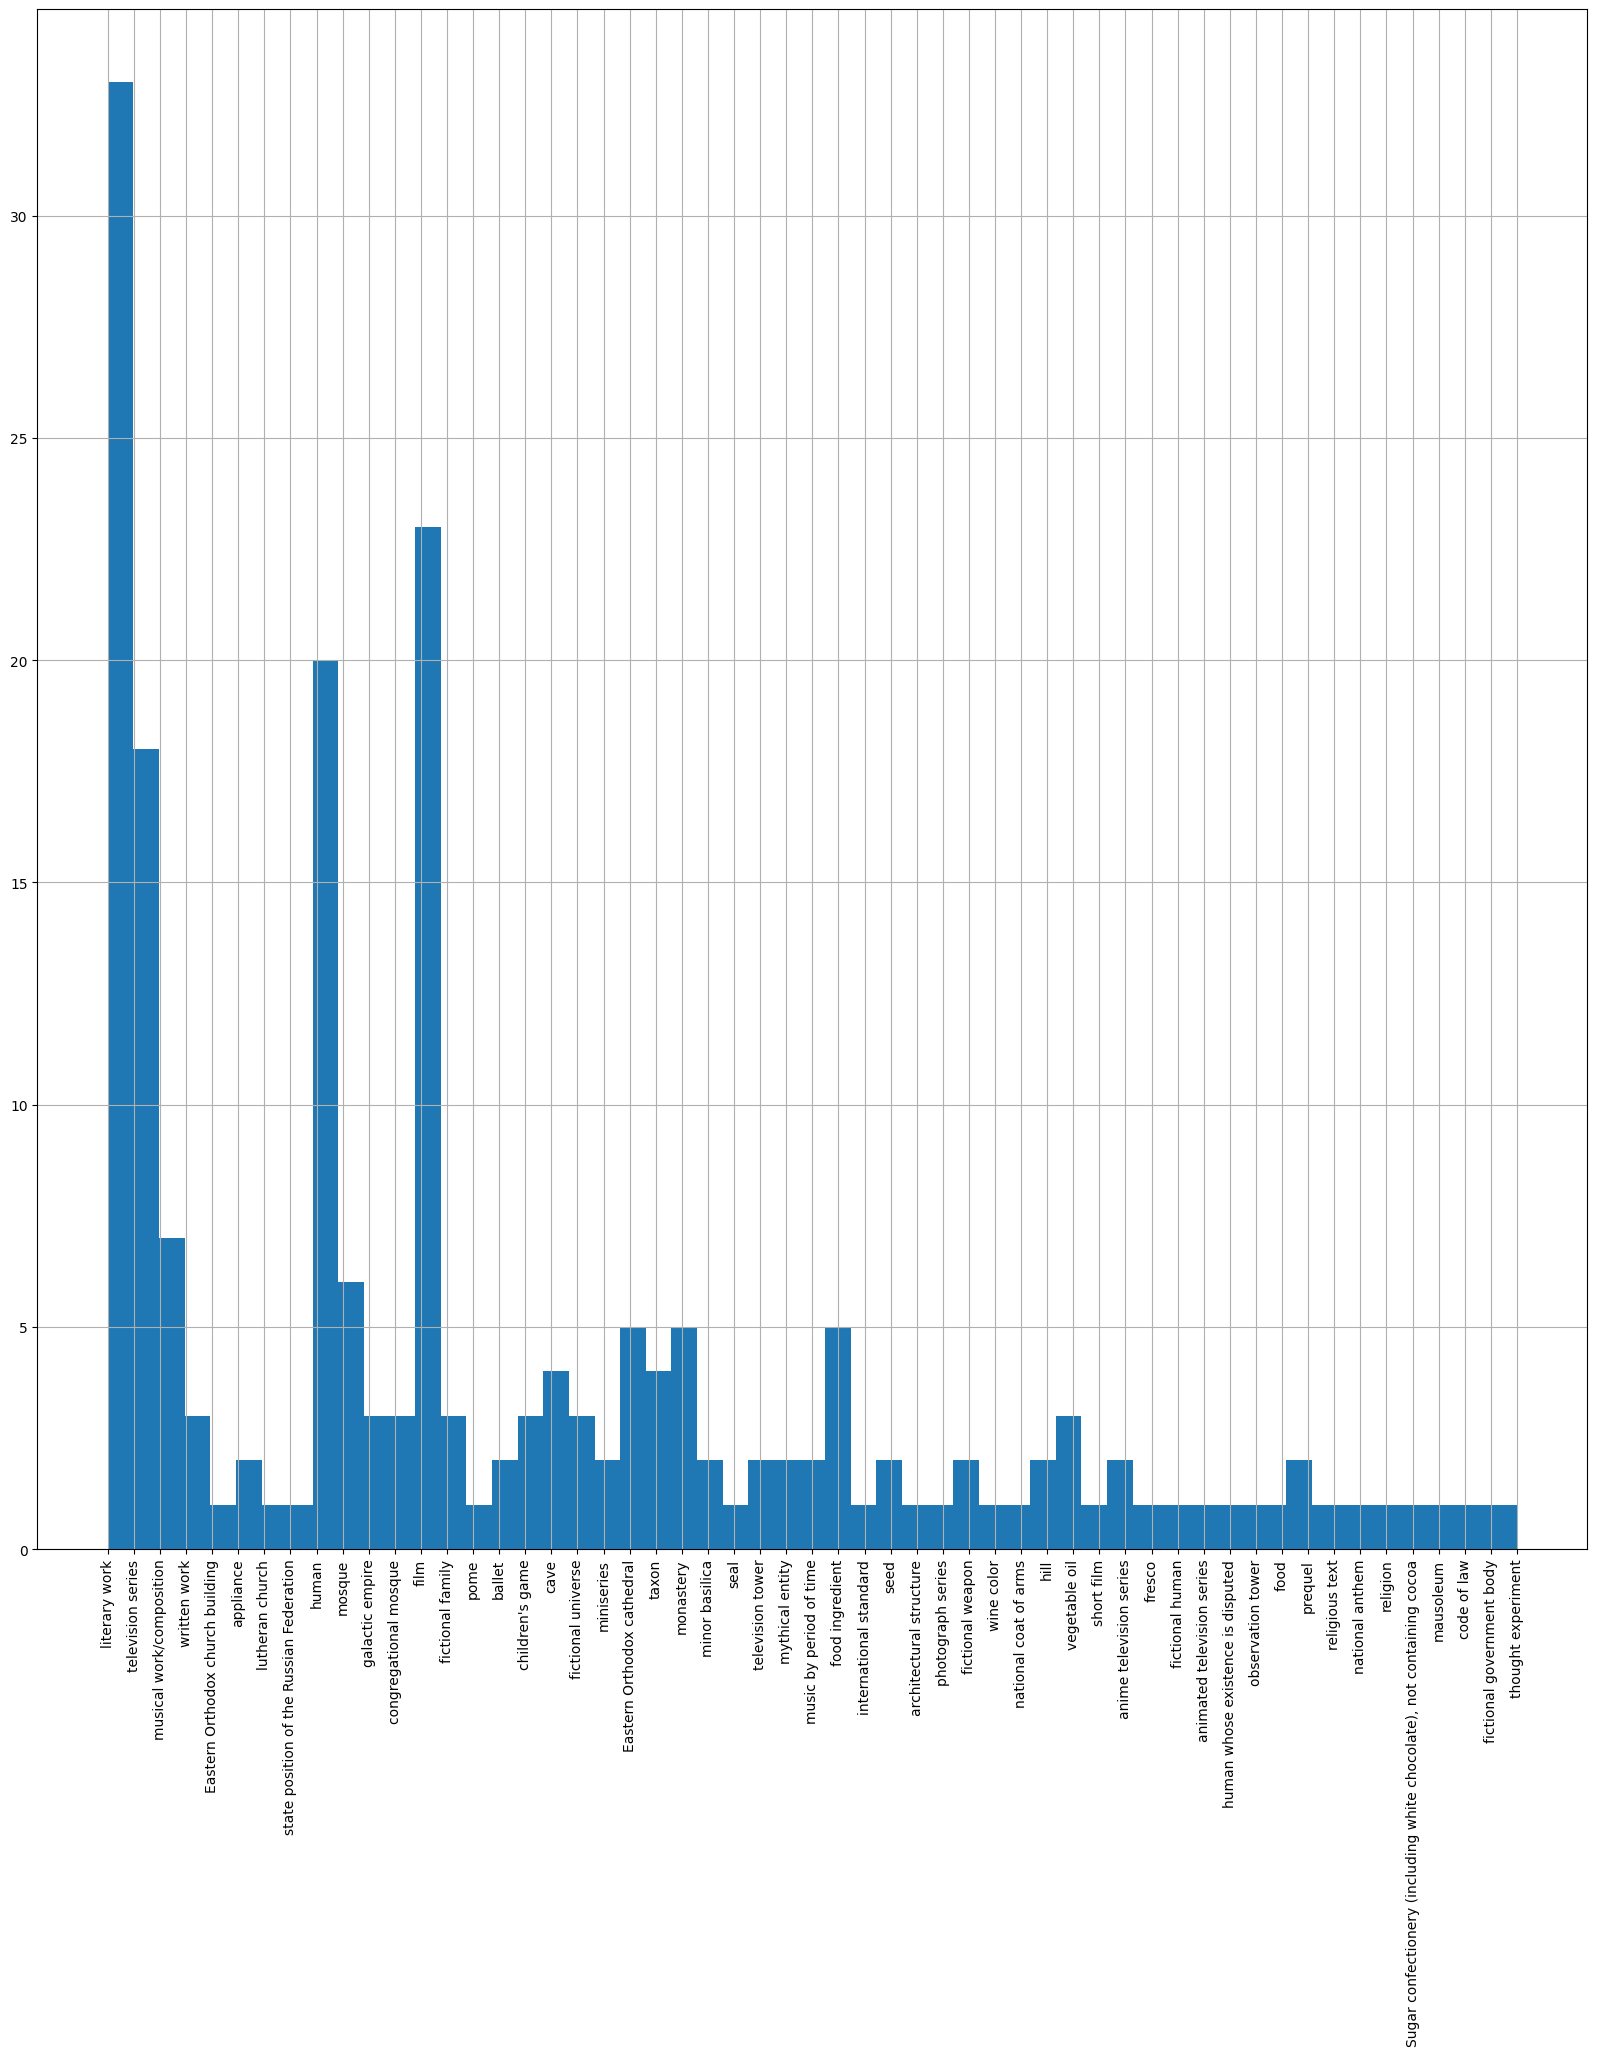

In [57]:
import collections
ts['instance_of'].hist(xrot=90, figsize=(20,20),bins=len(ts['instance_of'].unique()))

a = collections.Counter(ts['instance_of'])

In [69]:
a.most_common(5)

[('literary work', 33),
 ('film', 23),
 ('human', 20),
 ('television series', 18),
 ('musical work/composition', 7)]

In [72]:
a.most_common(50)

[('literary work', 33),
 ('film', 23),
 ('human', 20),
 ('television series', 18),
 ('musical work/composition', 7),
 ('mosque', 6),
 ('Eastern Orthodox cathedral', 5),
 ('monastery', 5),
 ('food ingredient', 5),
 ('cave', 4),
 ('taxon', 4),
 ('written work', 3),
 ('galactic empire', 3),
 ('congregational mosque', 3),
 ('fictional family', 3),
 ("children's game", 3),
 ('fictional universe', 3),
 ('vegetable oil', 3),
 ('appliance', 2),
 ('ballet', 2),
 ('miniseries', 2),
 ('minor basilica', 2),
 ('television tower', 2),
 ('mythical entity', 2),
 ('music by period of time', 2),
 ('seed', 2),
 ('fictional weapon', 2),
 ('hill', 2),
 ('anime television series', 2),
 ('prequel', 2),
 ('Eastern Orthodox church building', 1),
 ('lutheran church', 1),
 ('state position of the Russian Federation', 1),
 ('pome', 1),
 ('seal', 1),
 ('international standard', 1),
 ('architectural structure', 1),
 ('photograph series', 1),
 ('wine color', 1),
 ('national coat of arms', 1),
 ('short film', 1),
 ('

In [65]:
len(ts['ent_name'].unique())

122

In [66]:
len(ts['instance_of'].unique())

55

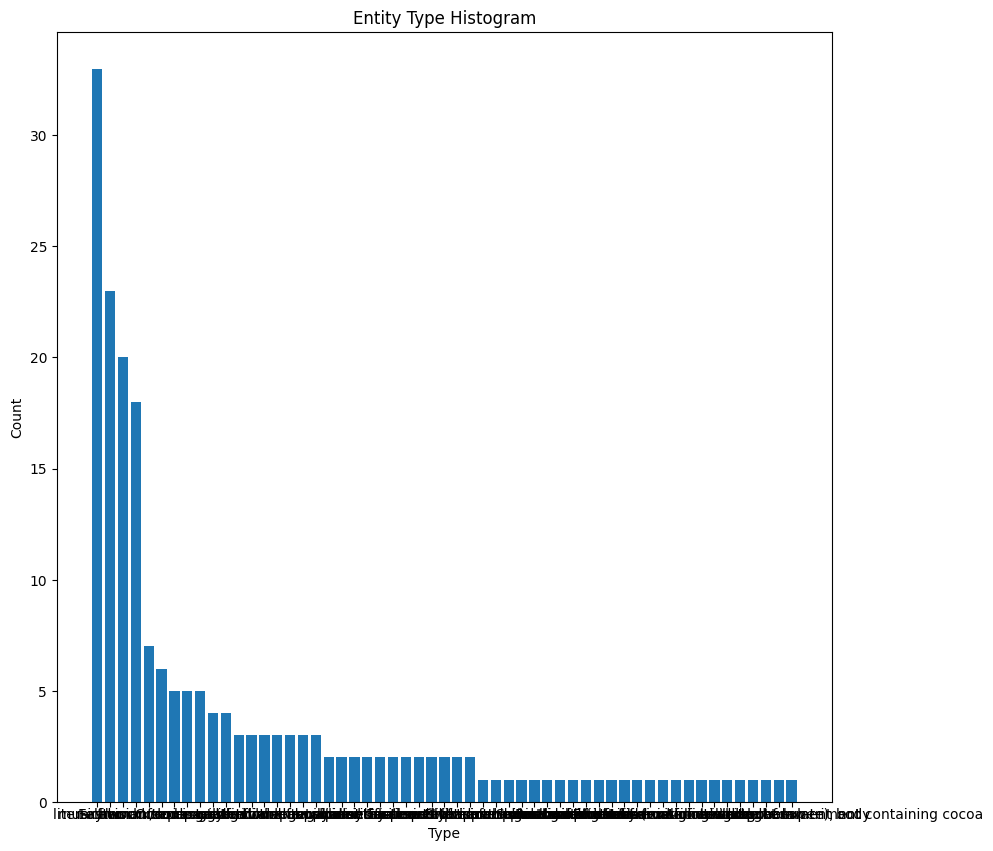

In [81]:
import matplotlib.pyplot as plt

categories = list(a.keys())
counts = list(a.values())



fig, ax = plt.subplots(1,1, figsize=(10,10))

# Create a histogram (bar plot)
x = []
y = []
for n,c in a.most_common():
    x.append(n)
    y.append(c)
ax.bar(x,y)


# Add labels and title
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.tick_params('x', pad=0.5)

plt.title('Entity Type Histogram')

# Show the plot
plt.show()

In [84]:
# Convert Counter to DataFrame
df = pd.DataFrame(a.most_common(), columns=['Entity', 'Count'])

# Display styled DataFrame
df.style.set_caption("Counter Table").set_table_styles(
    [{'selector': 'caption', 'props': 'caption-side: top; font-weight: bold; font-size: 14px;'}]
)

,Entity,Count
0,literary work,33
1,film,23
2,human,20
3,television series,18
4,musical work/composition,7
5,mosque,6
6,Eastern Orthodox cathedral,5
7,monastery,5
8,food ingredient,5
9,cave,4


In [99]:
ts[ts['instance_of']=='religion']

,ent_name,instance_of
161,LaVeyan Satanism,religion


In [97]:
1/a.total()

0.005

In [3]:
import pandas as pd
import os


In [13]:
ids = set()
fp = '../data/XC_test_data'
for item in os.listdir(fp):
    jl = pd.read_json(f'{fp}/{item}/test.jsonl',lines=True)
    print(len(jl))
    for item in jl['wikidata_id']:
        ids.add(item)

with open('test_ids.txt', 'w') as f:
    f.write('\n'.join(ids))

5108
5098
4547
5876
5465
5338


In [4]:
j = get_json('Q30')

In [5]:
import json
with open('t.txt', 'w') as f:
    f.write(json.dumps(j, indent=3))

In [7]:
j['entities']['Q30']['aliases']['en']

[{'language': 'en', 'value': 'United States'},
 {'language': 'en', 'value': 'the States'},
 {'language': 'en', 'value': 'the United States of America'},
 {'language': 'en', 'value': 'US of America'},
 {'language': 'en', 'value': 'USA'},
 {'language': 'en', 'value': 'U.S.A.'},
 {'language': 'en', 'value': 'America'},
 {'language': 'en', 'value': 'the US'},
 {'language': 'en', 'value': 'the U.S.'},
 {'language': 'en', 'value': 'the US of A'},
 {'language': 'en', 'value': 'U.S. of America'},
 {'language': 'en', 'value': 'the US of America'},
 {'language': 'en', 'value': 'US'},
 {'language': 'en', 'value': 'the USA'},
 {'language': 'en', 'value': 'U.S.'},
 {'language': 'en', 'value': 'the U.S.A.'},
 {'language': 'en', 'value': 'the U.S. of A'},
 {'language': 'en', 'value': 'US of A'},
 {'language': 'en', 'value': 'the U.S. of America'},
 {'language': 'en', 'value': 'U. S.'},
 {'language': 'en', 'value': 'U. S. A.'},
 {'language': 'en', 'value': 'the United States'},
 {'language': 'en', 'va

In [9]:
a = r.get('https://query.wikidata.org/#%23All%20properties%20with%20descriptions%20and%20aliases%20and%20types%0ASELECT%20%3Fproperty%20%3FpropertyType%20%3FpropertyLabel%20%3FpropertyDescription%20%3FpropertyAltLabel%20WHERE%20%7B%0A%20%20%3Fproperty%20wikibase%3ApropertyType%20%3FpropertyType%20.%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cmul%2Cen%22.%20%7D%0A%7D%0AORDER%20BY%20ASC%28xsd%3Ainteger%28STRAFTER%28STR%28%3Fproperty%29%2C%20%27P%27%29%29%29')
with open('t.txt', 'w') as f:
    f.write(a.text)

In [ ]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

def fetch_aliases(entity_ids): #SPARQL Query Wiki for aliases
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    results = []
    for i in range(0, len(entity_ids), 50):  # Adjust batch size
        batch = entity_ids[i:i + 50]
        query = """
        SELECT ?entity ?label ?alias WHERE {
          VALUES ?entity { %s }  # Replace with your entity IDs
          ?entity skos:altLabel ?alias.
          ?entity rdfs:label ?label.
          FILTER(LANG(?alias) = "en")  # Restrict aliases to English
          FILTER(LANG(?label) = "en")  # Restrict labels to English
        }
        """ % " ".join(f"wd:{id}" for id in batch)
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        res = sparql.query().convert()["results"]["bindings"]
        
        aliases = []
        for item in res:
          aliases.append((item['label']['value'], item['alias']['value']))


        results.extend(aliases)


    return results

In [35]:
import sqlite3

conn = sqlite3.connect('../database/ent.db')
cur = conn.cursor()

cur.execute('SELECT wiki_id from entity_translation')
res = cur.fetchall()
res

res = [i[0] for i in res]
res




['Q100',
 'Q1000',
 'Q1000684',
 'Q100097551',
 'Q1001056',
 'Q1002320',
 'Q1002362',
 'Q1003092',
 'Q1005',
 'Q100557141',
 'Q100573244',
 'Q1006293',
 'Q100873418',
 'Q1009',
 'Q10090',
 'Q1009896',
 'Q1010268',
 'Q1010828',
 'Q1011190',
 'Q1011547',
 'Q1012041',
 'Q101235198',
 'Q101236024',
 'Q101245321',
 'Q10132',
 'Q101384',
 'Q1014330',
 'Q101505',
 'Q101542406',
 'Q101609',
 'Q1016744',
 'Q1018679',
 'Q1018998',
 'Q1019',
 'Q101978',
 'Q101985',
 'Q1020603',
 'Q1020717',
 'Q1020994',
 'Q10210',
 'Q102113',
 'Q102141307',
 'Q102145',
 'Q102192',
 'Q102225',
 'Q102235',
 'Q102244',
 'Q10230',
 'Q1023103',
 'Q1024181',
 'Q102427',
 'Q102438',
 'Q102448',
 'Q102462',
 'Q1024946',
 'Q10264139',
 'Q1026417',
 'Q10264736',
 'Q10274722',
 'Q102754',
 'Q1027904',
 'Q1028',
 'Q10285',
 'Q10288',
 'Q10298203',
 'Q1031002',
 'Q1031890',
 'Q10319889',
 'Q1032',
 'Q103251',
 'Q1033',
 'Q103360',
 'Q10338664',
 'Q1034103',
 'Q103474',
 'Q103495',
 'Q1035',
 'Q1035067',
 'Q10351063',
 'Q10353

In [36]:
all_aliases = fetch_aliases(res)

In [37]:
all_aliases

[('Boston', 'Bostonia'),
 ('Boston', 'The Hub'),
 ('Boston', 'Boston, MA'),
 ('Boston', 'Boston, Massachusetts'),
 ('Boston', 'City of Boston'),
 ('Boston', 'Beantown'),
 ('Boston', 'Boston, Mass.'),
 ('Boston', 'Puritan City'),
 ('Boston', 'The Athens of America'),
 ('Boston', 'The Cradle of Liberty'),
 ('Boston', 'The Cradle of Modern America'),
 ('Boston', 'The Hub of the Universe'),
 ('Boston', 'The Walking City'),
 ('Boston', 'Bean Town'),
 ('Boston', 'Boston (MA)'),
 ('Boston', 'Boston MA, United States'),
 ('Boston', 'Boston, Massachusetts, United States'),
 ('Boston', 'Boston, Massachusetts, United States of America'),
 ('Boston', 'Boston, Massachusetts, US'),
 ('Boston', 'Boston, United States'),
 ('Boston', 'Boston, USA'),
 ('Boston', 'Capital of Massachusetts'),
 ('Boston', 'The hub of the universe'),
 ('Boston', 'Boston, Mass'),
 ('Gabon', 'Gabonese Republic'),
 ('Gabon', 'Republique Gabonaise'),
 ('Gabon', 'République Gabonaise'),
 ('The Gambia', 'Republic of the Gambia'),

In [46]:
cur.execute("""CREATE TABLE alias_table (
    name TEXT,
    alias TEXT PRIMARY KEY
);
            """
            )


In [52]:

for item in all_aliases:
    try:
        cur.execute('INSERT INTO alias_table (name, alias) VALUES (?, ?)', item)
    except sqlite3.IntegrityError:
        print('ITEM EXISTS IN DB', item)

ITEM EXISTS IN DB ('hip hop music', 'hip hop')
ITEM EXISTS IN DB ('hip hop music', 'hip-hop')
ITEM EXISTS IN DB ('John Adams', 'J. Adams')
ITEM EXISTS IN DB ('John Adams', 'President Adams')
ITEM EXISTS IN DB ('The Last Days of Pompeii', 'Last Days of Pompeii')
ITEM EXISTS IN DB ('The Legend of Zelda', 'Zelda')
ITEM EXISTS IN DB ('George I of Great Britain', 'George Hanover')
ITEM EXISTS IN DB ('George II of Great Britain', 'George Hanover')
ITEM EXISTS IN DB ('Maryland', 'MD')
ITEM EXISTS IN DB ('James IV of Scotland', 'James Stewart')
ITEM EXISTS IN DB ('Augustus', 'Gaius Julius Caesar')
ITEM EXISTS IN DB ('Caligula', 'Gaius Caesar')
ITEM EXISTS IN DB ('French', 'fr')
ITEM EXISTS IN DB ('Violin Concerto', 'Violin Concerto in D minor')
ITEM EXISTS IN DB ('Ramesses III', 'Rameses')
ITEM EXISTS IN DB ('Ramesses III', 'Ramses')
ITEM EXISTS IN DB ('Louisiana', 'LA')
ITEM EXISTS IN DB ('Charles VI of France', 'Charles VI')
ITEM EXISTS IN DB ('War and Peace', 'War & Peace')
ITEM EXISTS IN D

In [53]:
conn.commit()

In [54]:
conn.close()

In [60]:
conn = sqlite3.connect('../database/ent.db')
cur = conn.cursor()
cur.execute('SELECT name FROM alias_table WHERE alias like "US"')
cur.fetchall()

[('United States of America',)]